<a href="https://colab.research.google.com/github/Chromis07/dataStudy/blob/main/ML/sklearn/Titanic_Classification_Ensemble_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries for reading and handling the data
import numpy as np 
import pandas as pd
import re

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split # 일반적인 함수들은 소문자
from sklearn.preprocessing import StandardScaler # 객체를 생성하거나 뭘 해야되는애들은 대문자, 스케일을 0~1 로 조정
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


# Libraries for creating ML model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Library for Analysing the ML model
from sklearn import metrics #평가를 위한라이브러리

데이터 준비하기

In [2]:
train_path = 'train.csv'

target = 'Survived'

index = 'PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

titanic = pd.read_csv(train_path, index_col=index, dtype=dtypes)

In [3]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


데이터 시각화

In [5]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

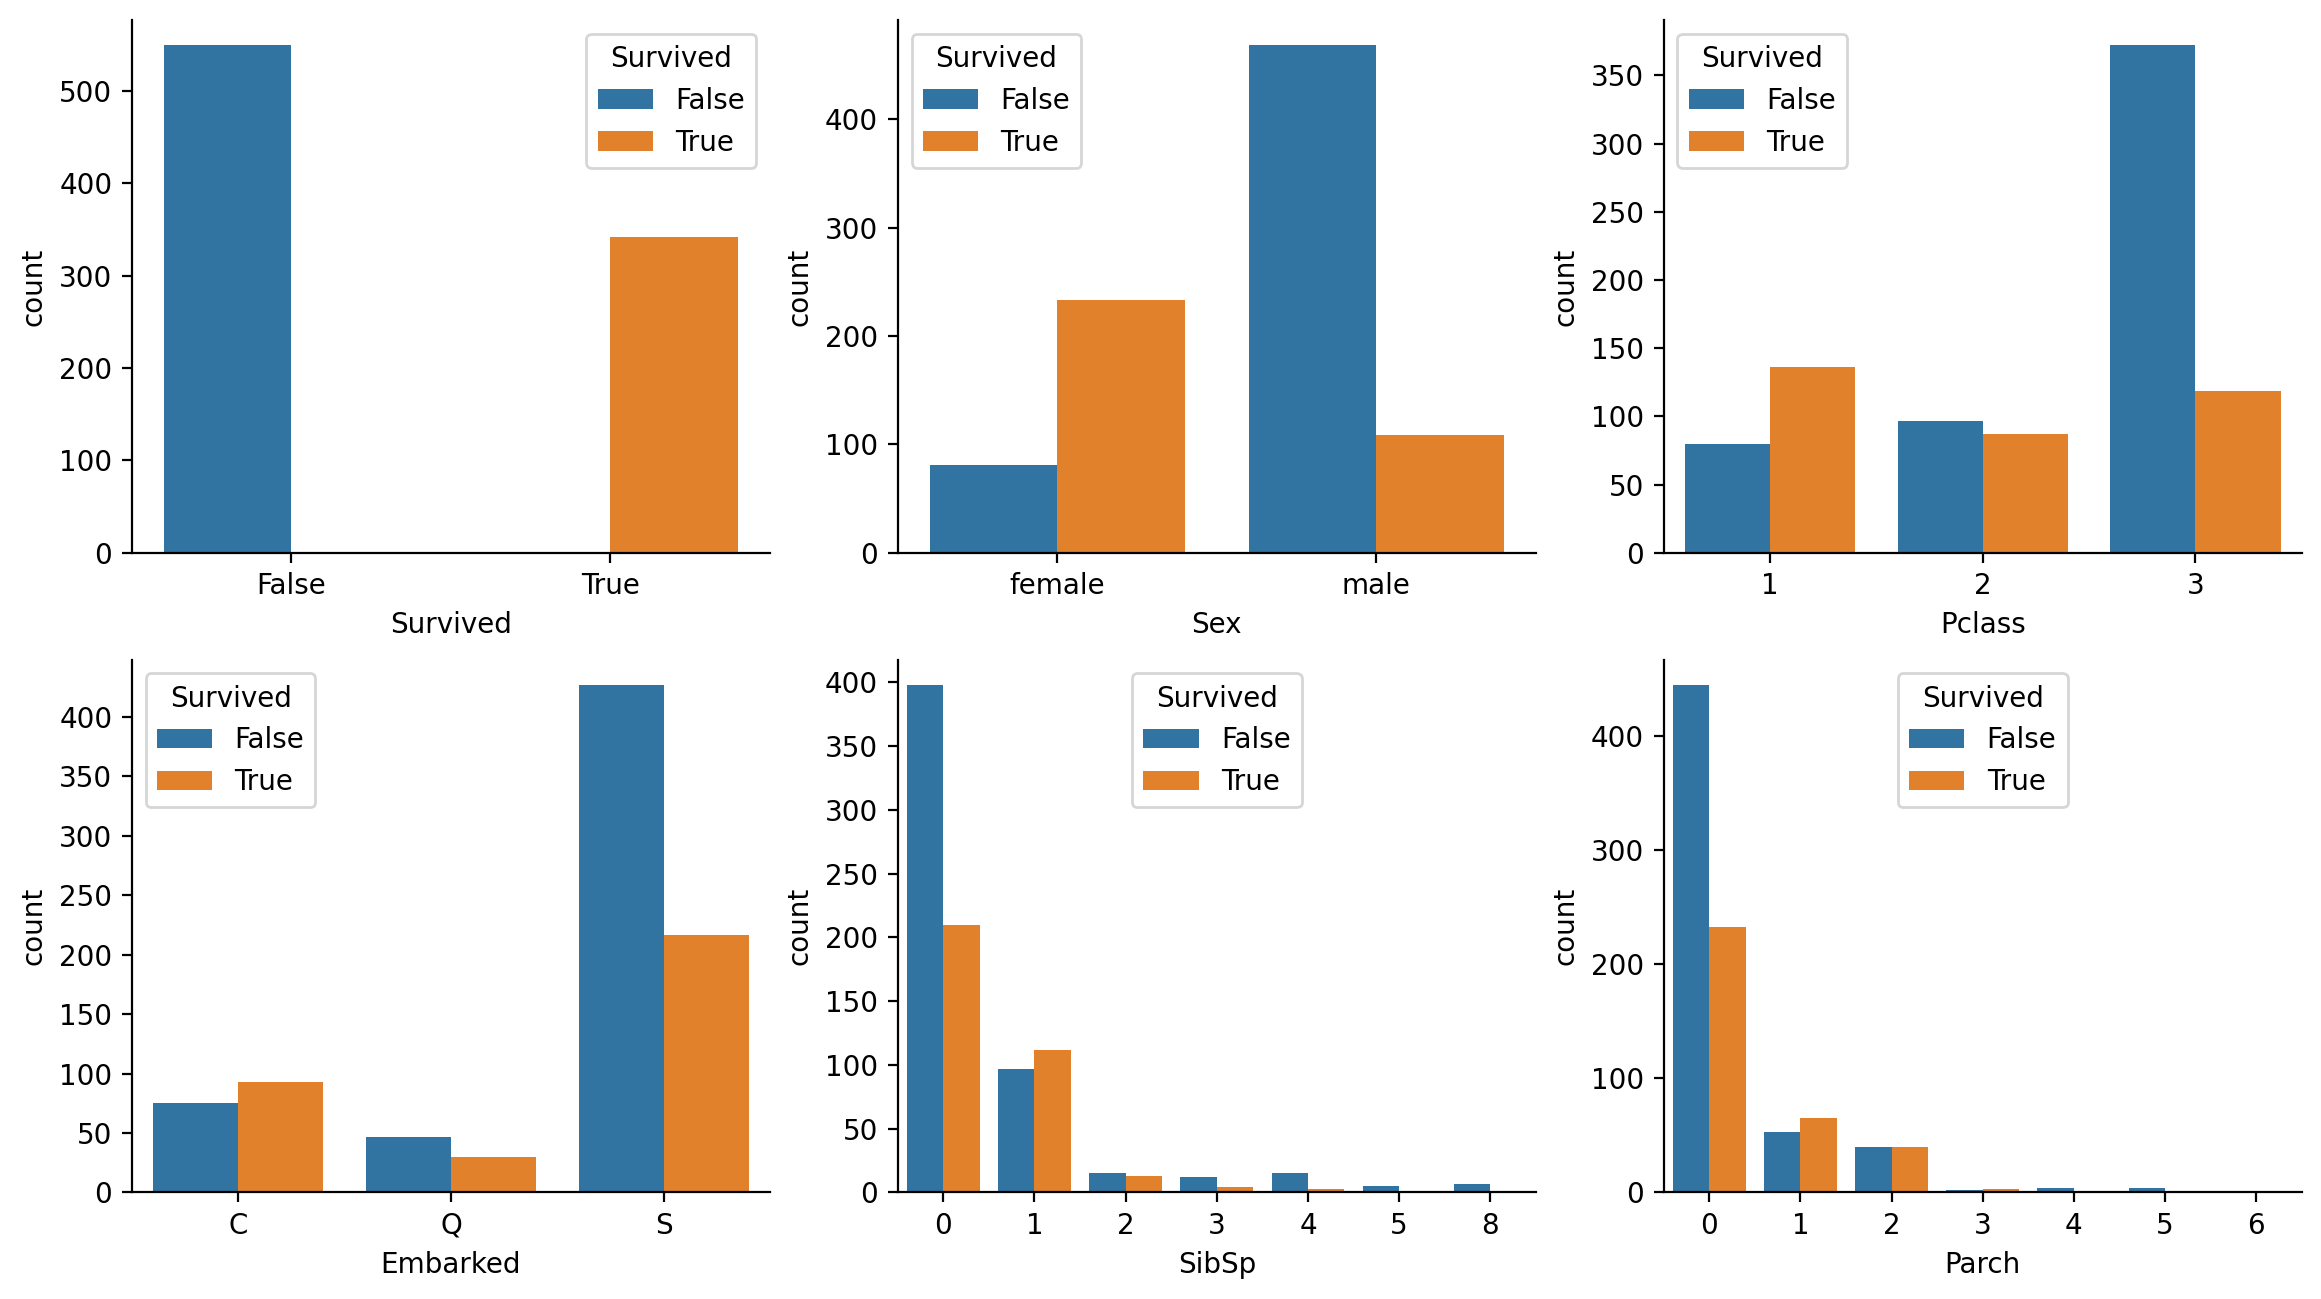

In [6]:
attributes = ['Survived', 'Sex' , 'Pclass', 'Embarked', 'SibSp', 'Parch']

plt.figure(figsize=(14,12), dpi=200)

for i, feature in enumerate(attributes) :
  plt.subplot(3,3,i+1)
  sns.countplot(data=titanic, x=feature, hue='Survived')

sns.despine()

# 이진 분류 일때만 사용 가능

데이터 전처리

In [7]:
titanic['Name'].iloc[0:5]

# 이름 앞에 Mr, Mrs 등으로 정보를 얻을 수 있다

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [8]:
def get_title(name) :
  return re.split(',|\.', name)[1].strip()

In [9]:
# 이름에서 호칭 추출 (Miss, Mrs ...)
titanic['title'] = titanic['Name'].apply(get_title)

In [10]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
PassengerId,,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [11]:
# 호칭이 생존에 과연 영향을 끼치는지 확인을 위해 집계 함수 -> 카운트, 평균
titles = titanic.groupby('title').agg({'Survived' : ['count', 'mean']})

In [12]:
# Survived 컬럼 레이어 정리
titles.columns = titles.columns.droplevel()

In [13]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean', ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [14]:
# 호칭 추출이 되지 않은 title 값을 Other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])

titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

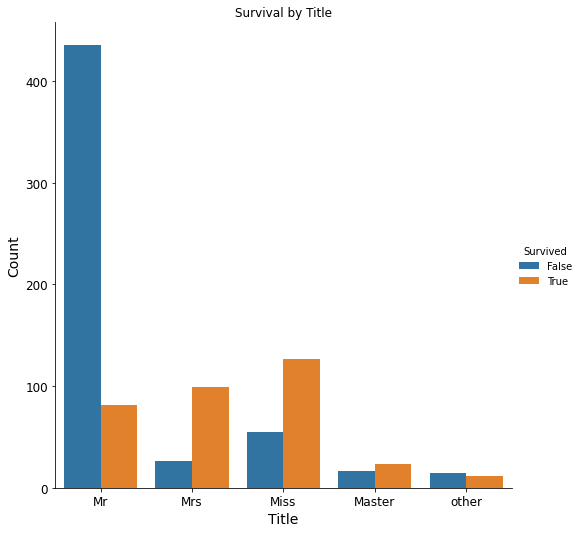

In [15]:
sns.catplot(x='title', kind = 'count', hue='Survived', data=titanic,
            height=7)

plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Title', fontsize=14)
plt.title('Survival by Title')
plt.show()

In [16]:
# 가족 사이즈(fam_size) -> SibSp(동승한 자매 or 배우자) + Parch(동승한 부모 or 자식수)
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

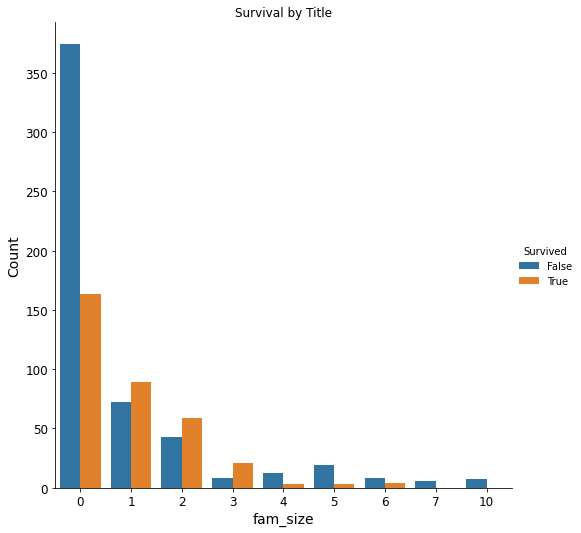

In [17]:
sns.catplot(x='fam_size', kind='count', hue='Survived',
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('fam_size', fontsize=14)
plt.title('Survival by Title')
plt.show()

ML을 위한 전처리

In [18]:
# 텍스트 데이터 삭제
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)

In [19]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [20]:
# 여성을 1로, 남성을 0으로 처리
tmp = []

for each in titanic['Sex'] :
  if each == 'female' :
    tmp.append(1)
  elif each == 'male' :
    tmp.append(0)
  else :
    tmp.append(np.nan)

titanic['Sex'] = tmp

In [21]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


데이터 형변환 및 결손 데이터 처리

In [22]:
#데이터 형 변환 (소수점)
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

데이터 분리하기 X, y

In [23]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis=1)

train / test 분리하기

In [144]:
X_train, X_test, y_train, y_test = train_test_split(titanic, 
                                                    titanic_labels, 
                                                    train_size=0.8, 
                                                    random_state=500)

머신 러닝 모델 구축 - 1) LogisticRegression

In [145]:
log_reg = LogisticRegression().fit(X_train,y_train)

In [146]:
# 정확도 확인
print('Train data Score :' , log_reg.score(X_train,y_train))
print('Test data score : ' , log_reg.score(X_test,y_test))

Train data Score : 0.809106830122592
Test data score :  0.8181818181818182


머신러닝 모델 구축 2) Decision Tree

In [147]:
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=20,
                              min_samples_split=40).fit(X_train, y_train)

In [148]:
# 정확도 확인
print('Train data Score :' , tree.score(X_train,y_train))
print('Test data score : ' , tree.score(X_test,y_test))

Train data Score : 0.8143607705779334
Test data score :  0.8321678321678322


머신러닝 모델 구축 3) GradientBoostingClassifier

In [149]:
boost = GradientBoostingClassifier(max_depth=3,
                                   learning_rate=0.05).fit(X_train,y_train)

In [150]:
# 정확도 확인
print('Train data Score : ', boost.score(X_train, y_train))
print('Test data Score : ', boost.score(X_test, y_test))

Train data Score :  0.8809106830122592
Test data Score :  0.8391608391608392


머신러닝 모델 구축 4) RandomForestClassifier

In [151]:
random = RandomForestClassifier(n_estimators=300,
                                   random_state=0).fit(X_train,y_train)

In [152]:
# 정확도 확인
print('Train data Score : ', random.score(X_train, y_train))
print('Test data Score : ', random.score(X_test, y_test))

Train data Score :  0.989492119089317
Test data Score :  0.7902097902097902


성능평가 - ROC 커브

In [153]:
# ROC curve 함수
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

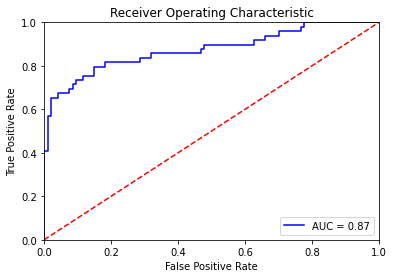

In [154]:
# Logistic Regression ROC
plot_auc_roc(log_reg)

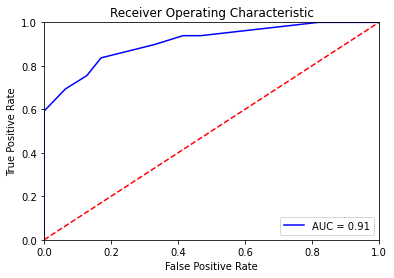

In [155]:
# Decision Tree ROC
plot_auc_roc(tree)

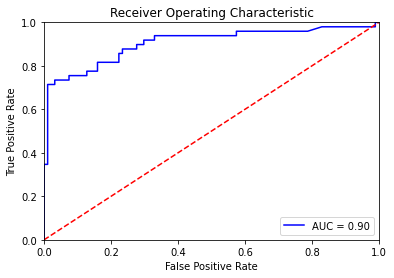

In [156]:
# GradientBoosingClassifier ROC
plot_auc_roc(boost)

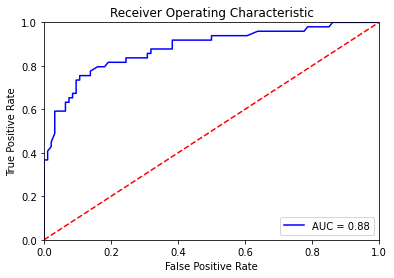

In [157]:
# RandomForestClassifier ROC
plot_auc_roc(random)

성능평가 - 평가지표(classification_report)

In [158]:
# Logistic Regression 평가 지표
lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test, lg_y_hat)
print('Logistic Regression 평가 지표')
print(lg_report)
print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )

Logistic Regression 평가 지표
              precision    recall  f1-score   support

       False       0.89      0.83      0.86        94
        True       0.71      0.80      0.75        49

    accuracy                           0.82       143
   macro avg       0.80      0.81      0.80       143
weighted avg       0.83      0.82      0.82       143

accuracy 0.8181818181818182
precision 0.7090909090909091
recall 0.7959183673469388
f1 0.75


In [159]:
# Decision Tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test, tree_y_hat)
print('Logistic Regression 평가 지표')
print(tree_report)
print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )

Logistic Regression 평가 지표
              precision    recall  f1-score   support

       False       0.89      0.85      0.87        94
        True       0.74      0.80      0.76        49

    accuracy                           0.83       143
   macro avg       0.81      0.82      0.82       143
weighted avg       0.84      0.83      0.83       143

accuracy 0.8321678321678322
precision 0.7358490566037735
recall 0.7959183673469388
f1 0.7647058823529412


In [160]:
# GradientBoosingClassifier 평가 지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test, boost_y_hat)
print('GradientBoosingClassifier 평가 지표')
print(boost_report)
print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )

GradientBoosingClassifier 평가 지표
              precision    recall  f1-score   support

       False       0.88      0.87      0.88        94
        True       0.76      0.78      0.77        49

    accuracy                           0.84       143
   macro avg       0.82      0.82      0.82       143
weighted avg       0.84      0.84      0.84       143

accuracy 0.8391608391608392
precision 0.76
recall 0.7755102040816326
f1 0.7676767676767676


In [161]:
# RandomForestClassifier 평가 지표
random_y_hat = random.predict(X_test)
random_report = metrics.classification_report(y_test, random_y_hat)
print('GradientBoosingClassifier 평가 지표')
print(boost_report)
print('accuracy', metrics.accuracy_score(y_test,random_y_hat) )
print('precision', metrics.precision_score(y_test,random_y_hat) )
print('recall', metrics.recall_score(y_test,random_y_hat) )
print('f1', metrics.f1_score(y_test,random_y_hat) )

GradientBoosingClassifier 평가 지표
              precision    recall  f1-score   support

       False       0.88      0.87      0.88        94
        True       0.76      0.78      0.77        49

    accuracy                           0.84       143
   macro avg       0.82      0.82      0.82       143
weighted avg       0.84      0.84      0.84       143

accuracy 0.7902097902097902
precision 0.6557377049180327
recall 0.8163265306122449
f1 0.7272727272727273


성능평가 - precision_score, recall_score 각 모델별로 추출한 후 그래프로 시각화

In [162]:
precision_list = []
recall_list = []

precision_list.append(metrics.precision_score(y_test, lg_y_hat))
recall_list.append(metrics.recall_score(y_test, lg_y_hat))

precision_list.append(metrics.precision_score(y_test, tree_y_hat))
recall_list.append(metrics.recall_score(y_test, tree_y_hat))

precision_list.append(metrics.precision_score(y_test, boost_y_hat))
recall_list.append(metrics.recall_score(y_test, boost_y_hat))

precision_list.append(metrics.precision_score(y_test, random_y_hat))
recall_list.append(metrics.recall_score(y_test, random_y_hat))

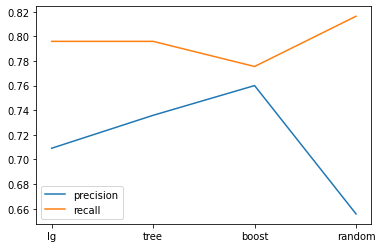

In [163]:
plt.plot(['lg', 'tree', 'boost', 'random'], precision_list, label='precision')
plt.plot(['lg', 'tree', 'boost', 'random'], recall_list, label='recall')
plt.legend()
plt.show()
# 사망, 진료 등은 recall (오진단 시 critical할 경우), 추천 알고리즘은 precision
# 그러므로 RandomforestClassifier가 가장 적합한 모델 (F1 score는 Boosting이 좋음)